In [51]:
#GPU확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
import os #파일경로 불러오기용
import cv2 #이미지 처리용
import pandas as pd #데이터 프레임 조작용

In [9]:
def create_df(data_path):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        img_path_list.append(img_path)
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [10]:
df = create_df('natural_images')

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
airplane 727
car 968
cat 885
dog 702
flower 843
fruit 1000
motorbike 788
person 986


In [11]:
display(df)

File_path   Label
0     natural_images/person/person_0708.jpg  person
1           natural_images/dog/dog_0120.jpg     dog
2           natural_images/cat/cat_0613.jpg     cat
3       natural_images/fruit/fruit_0759.jpg   fruit
4           natural_images/dog/dog_0189.jpg     dog
...                                     ...     ...
6894    natural_images/fruit/fruit_0806.jpg   fruit
6895        natural_images/dog/dog_0684.jpg     dog
6896        natural_images/car/car_0926.jpg     car
6897        natural_images/dog/dog_0027.jpg     dog
6898        natural_images/dog/dog_0152.jpg     dog

[6899 rows x 2 columns]

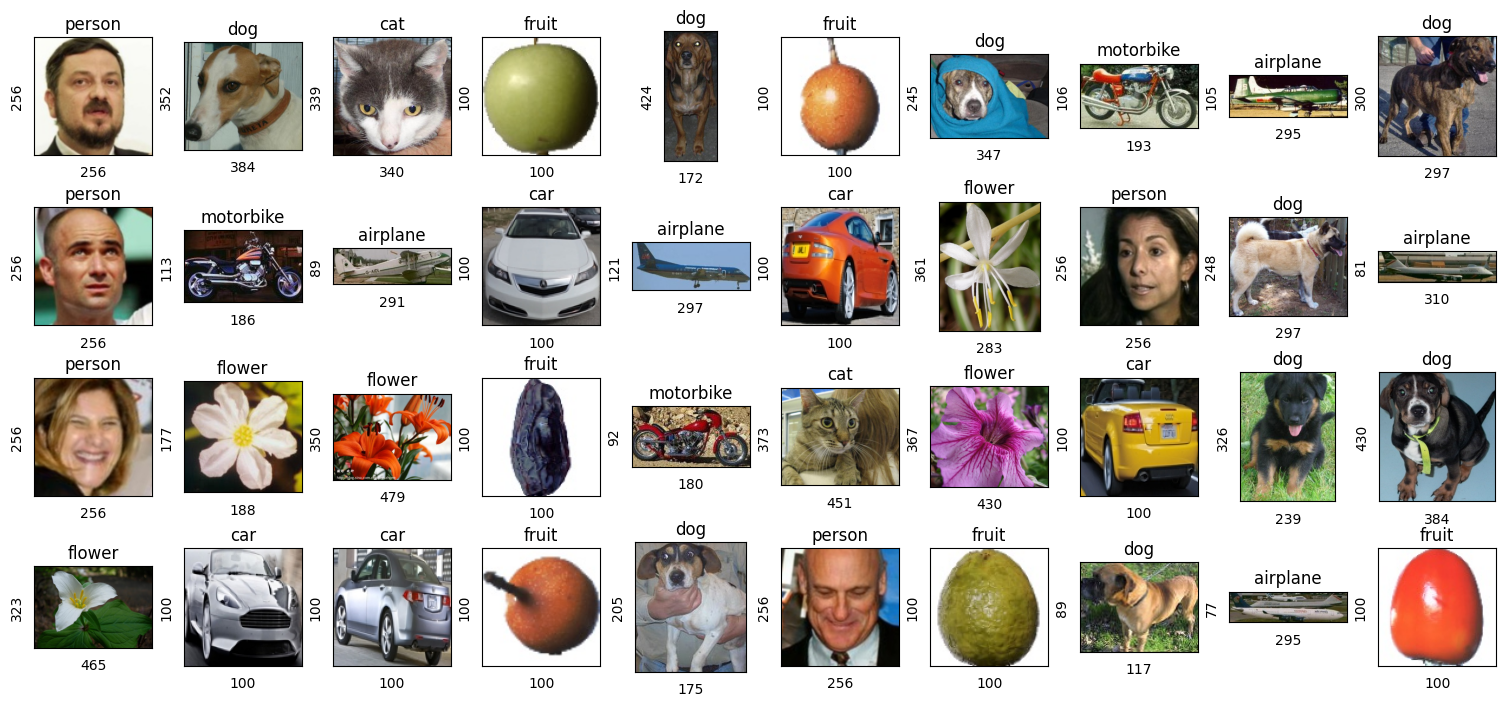

In [5]:
import matplotlib.pyplot as plt
"""
  데이터 확인(이미지 라벨, 가로크기,세로크기)
"""
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.File_path[i]))
    img = cv2.imread(df.File_path[i])
    ax.set_title(df.Label[i], fontsize = 12)
    ax.set_xlabel(img.shape[1], fontsize=10)
    ax.set_ylabel(img.shape[0], fontsize=10)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
"""
  훈련데이터,테스트데이터로 나누기, 9:1, 계층샘플링적용
"""
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0,stratify=df.Label)
train_df.shape,test_df.shape


((6209, 2), (690, 2))

In [12]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [15]:
import time
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = time.perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = time.perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.


DenseNet121          trained in 28.57 sec
9420800/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 12.98 sec
74850304/74836368 [==============================] - 9s 0us/step
DenseNet201          trained in 39.12 sec
16719872/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 17.59 sec
27033600/27018416 [==============================] - 4s 0us/step
EfficientNetB1       trained in 22.92 sec
87924736/87910968 [==============================] - 15s 0us/step
InceptionV3          trained in 22.46 sec
12697600/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 14.21 sec
234561536/234545216 [==============================] - 33s 0us/step
ResNet152V2          trained in 54.55 sec
94781440/94765736 [=====

In [20]:
# test데이터로 모델 성능 예측
from sklearn.metrics import accuracy_score
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['accuracy'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['accuracy'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 99.71% accuracy on the test set**
**MobileNetV2 has a 99.13% accuracy on the test set**
**DenseNet201 has a 99.86% accuracy on the test set**
**EfficientNetB0 has a 14.78% accuracy on the test set**
**EfficientNetB1 has a 14.49% accuracy on the test set**
**InceptionV3 has a 98.84% accuracy on the test set**
**MobileNetV3Large has a 68.99% accuracy on the test set**
**ResNet152V2 has a 99.86% accuracy on the test set**
**ResNet50 has a 74.93% accuracy on the test set**
**ResNet50V2 has a 99.42% accuracy on the test set**
**VGG19 has a 97.68% accuracy on the test set**
**VGG16 has a 97.54% accuracy on the test set**
**Xception has a 99.86% accuracy on the test set**


model  val_accuracy  accuracy  Training time (sec)
0        DenseNet201        0.9984    0.9986                39.12
1        ResNet152V2        1.0000    0.9986                54.55
2           Xception        1.0000    0.9986                29.56
3        DenseNet121        0.9952    0.9971                28.57
4         ResNet50V2        0.9952    0.9942                19.76
5        MobileNetV2        0.9984    0.9913                12.98
6        InceptionV3        0.9952    0.9884                22.46
7              VGG19        0.9903    0.9768                48.03
8              VGG16        0.9790    0.9754                35.44
9           ResNet50        0.7419    0.7493                24.38
10  MobileNetV3Large        0.7113    0.6899                14.21
11    EfficientNetB0        0.1371    0.1478                17.59
12    EfficientNetB1        0.1548    0.1449                22.92

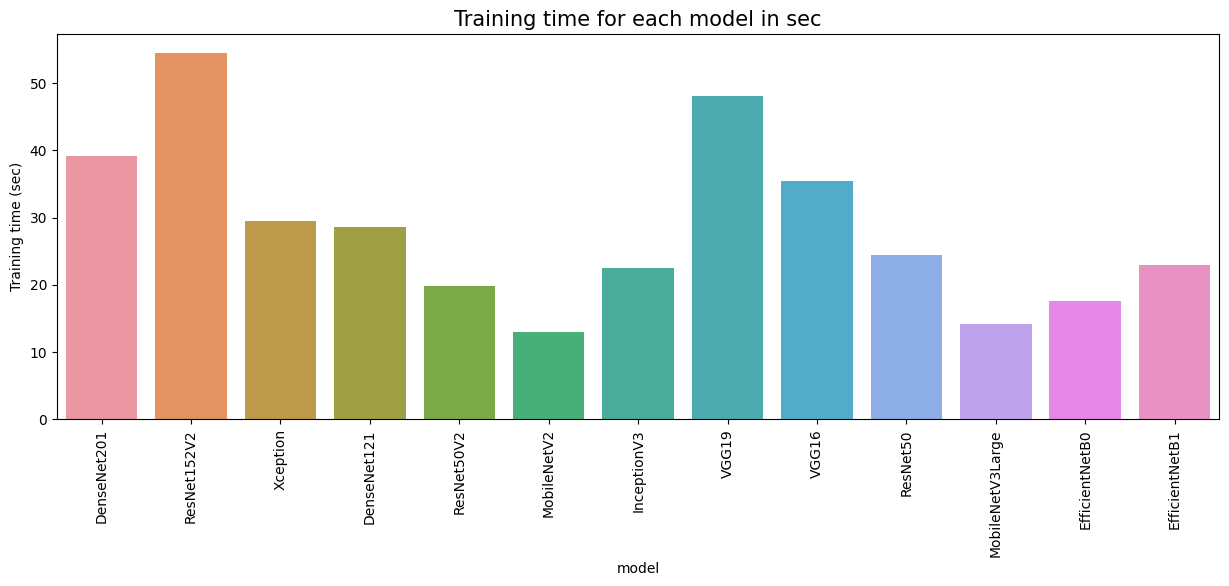

In [22]:
import seaborn as sns
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [23]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)


Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.
Epoch 1/7
175/175 [==============================] - 35s 166ms/step - loss: 0.0931 - accuracy: 0.9760 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 2/7
175/175 [==============================] - 27s 155ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.0097 - val_accuracy: 0.9968
Epoch 3/7
175/175 [==============================] - 27s 156ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9984
Epoch 4/7
175/175 [==============================] - 29s 165ms/step - loss: 5.0947e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 5/7
175/175 [==============================] - 29s 168ms/step - loss: 6.8425e-05 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9984
Epoch 6/7
175/175 [==============================] - 30s 169ms/step - loss: 4.1354e-05 - ac

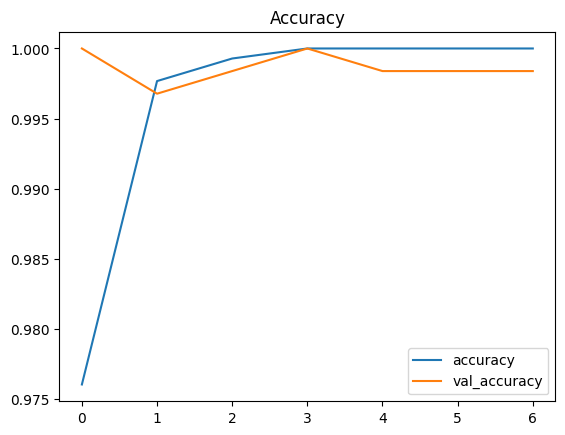

In [24]:
#정확도그래프
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

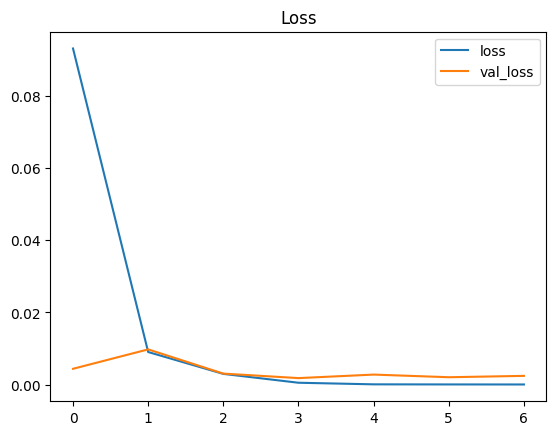

In [25]:
#오차그래프
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=5)

Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.
Epoch 1/5
175/175 [==============================] - 54s 277ms/step - loss: 0.0623 - accuracy: 0.9848 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/5
175/175 [==============================] - 46s 265ms/step - loss: 8.4437e-04 - accuracy: 0.9996 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 3/5
175/175 [==============================] - 46s 264ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 5.3650e-04 - val_accuracy: 1.0000
Epoch 4/5
175/175 [==============================] - 46s 264ms/step - loss: 7.2472e-04 - accuracy: 0.9995 - val_loss: 3.6152e-04 - val_accuracy: 1.0000
Epoch 5/5
175/175 [==============================] - 46s 265ms/step - loss: 3.9797e-05 - accuracy: 1.0000 - val_loss: 3.4181e-04 - val_accuracy: 1.0000


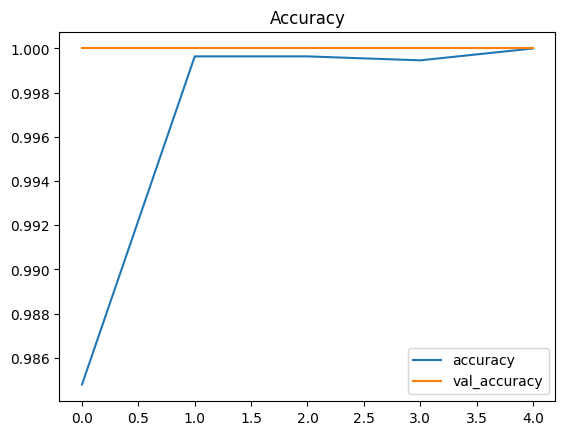

In [27]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

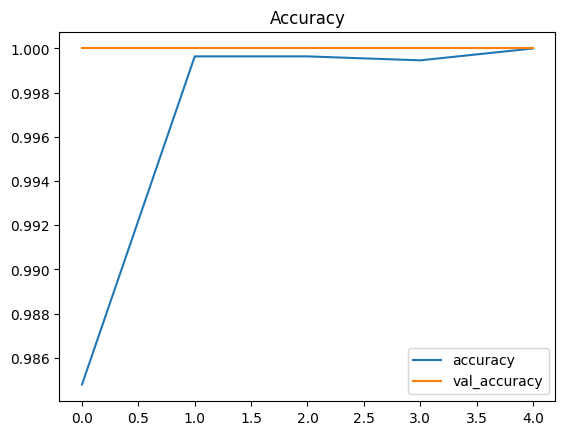

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [30]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00        73
         car       1.00      1.00      1.00        97
         cat       0.99      1.00      0.99        88
         dog       1.00      0.99      0.99        70
      flower       1.00      1.00      1.00        84
       fruit       1.00      1.00      1.00       100
   motorbike       1.00      1.00      1.00        79
      person       1.00      1.00      1.00        99

    accuracy                           1.00       690
   macro avg       1.00      1.00      1.00       690
weighted avg       1.00      1.00      1.00       690



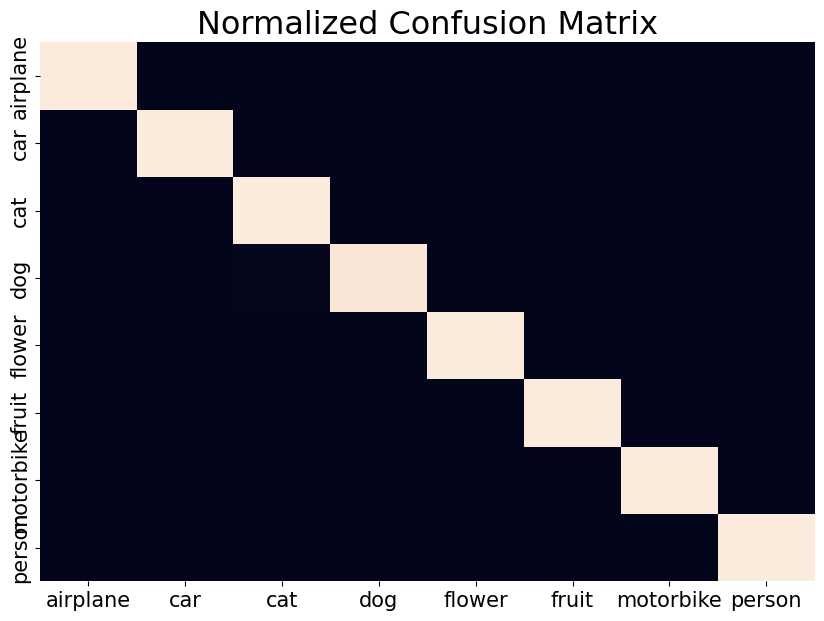

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [32]:
model.save('ResNet152V2.h5')

번호를 입력하세요 :  10


'예측률 : 100.00%'

'Class prediction = dog'

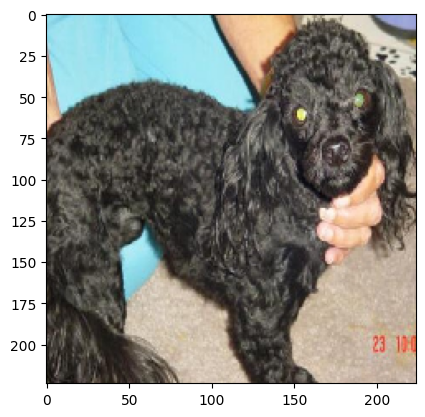

In [13]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.resnet_v2 import preprocess_input
model = load_model('ResNet152V2.h5')
def printmd(string):
    # Print with Markdowns    
    display(string)
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"Class prediction = {x}")
    break

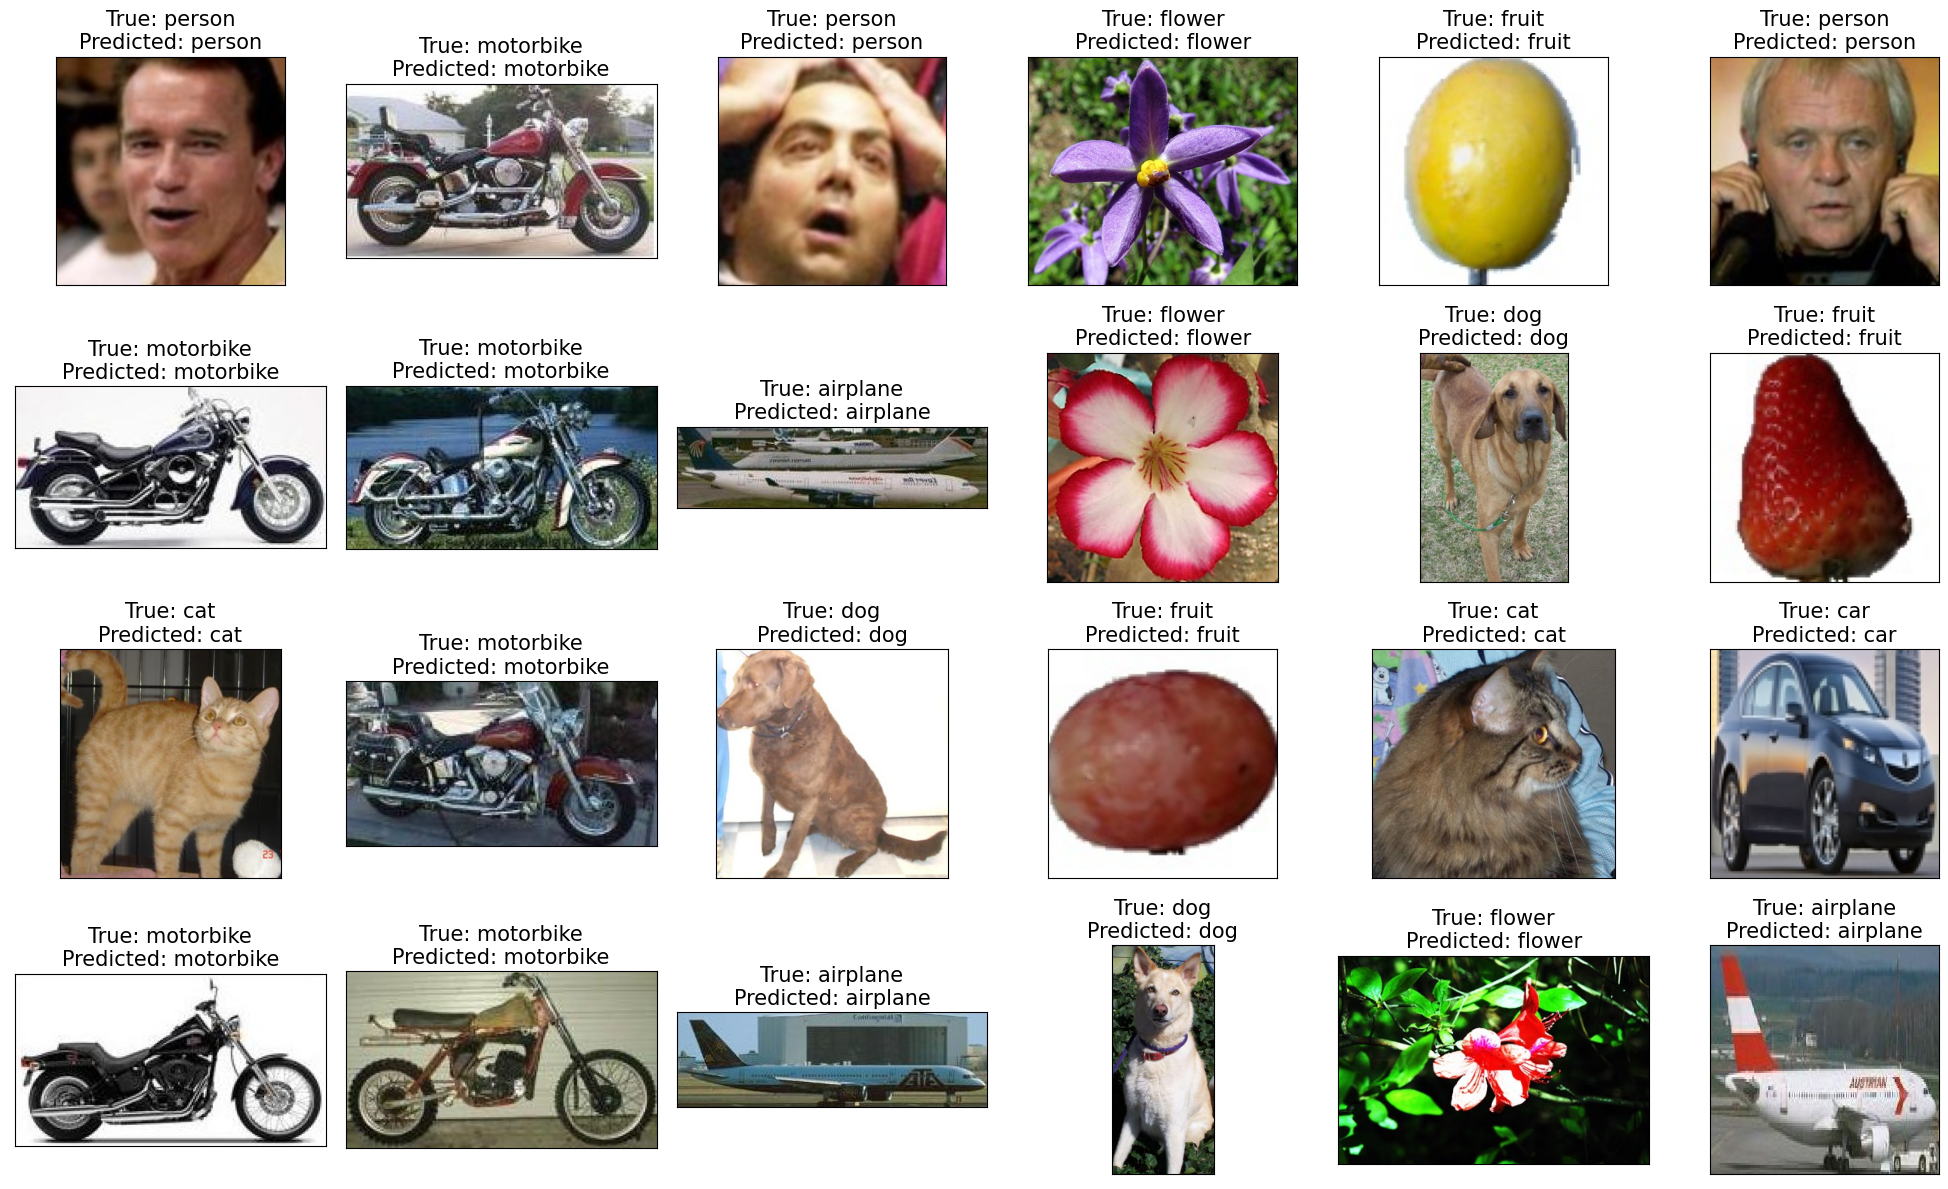

In [57]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    plt.imshow(test_image/255.);

    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
        if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
            ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
            break
plt.tight_layout()
plt.show()


In [29]:
from keras.preprocessing import image
from keras.models import load_model

import tensorflow as tf
model = load_model('ResNet152V2.h5')
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)
test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False)
scores = model.evaluate(test_images)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

Found 690 validated image filenames belonging to 8 classes.
22/22 [==============================] - 5s 206ms/step - loss: 3.0545e-05 - accuracy: 1.0000
[3.0545492336386815e-05, 1.0]
accuracy: 100.00%
